In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
import skexplain
from os.path import join
import pickle
from skexplain.plot.base_plotting import PlotStructure
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import joblib
from bayeshist import bayesian_histogram, plot_bayesian_histogram
import matplotlib.pyplot as plt
from display_names import to_readable_names, get_units
from matplotlib.ticker import MaxNLocator

In [2]:
import xarray as xr
def to_xarray(shap_data, estimator_name, feature_names=None):
    dataset={}
    
    shap_values = shap_data['shap_values']
    bias = shap_data['bias']
    
    dataset[f'shap_values__{estimator_name}'] = (['n_examples', 'n_features'], shap_values)
    dataset[f'bias__{estimator_name}'] = (['n_examples'], bias.astype(np.float64))
    dataset['X'] = (['n_examples', 'n_features'], shap_data['X'])
    dataset['y'] = (['n_examples'], shap_data['targets'])
    
    ds = xr.Dataset(dataset)
    #ds.attrs['features'] = feature_names
    
    return ds 

In [3]:
hazard = 'tornado'
estimator_name = 'LogisticRegression'

# Load the WoFS data. 
base_path = '/work/mflora/ML_DATA/DATA'
data_path = join(base_path, f'original_first_hour_training_matched_to_{hazard}_0km_data.feather')
df = pd.read_feather(data_path)


# Load the WoFS-ML-Severe Models
base_path = '/work/mflora/ML_DATA/MODEL_SAVES'
model_name = 'LogisticRegression'
model_paths = glob(join(base_path, f'{model_name}_first_hour_{hazard}*'))
model_path = [m for m in model_paths if 'manual' not in m][0]
model_data = joblib.load(model_path)

model = model_data['model']
feature_names = model_data['features']

X = df[feature_names].astype(float)
y = df[f'matched_to_{hazard}_0km'].astype(float)

display_feature_names = {f : to_readable_names(f) for f in feature_names}
display_units = {f : get_units(f) for f in feature_names}

In [4]:
explainer = skexplain.ExplainToolkit(estimators = ('LogisticRegression', model), X=X,y=y)
ice_curves = explainer.ice(features=['comp_dz_time_max_ens_mean_of_90th'], 
                           subsample = 500, 
                          )

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
ice_curves

<xarray.Dataset>
Dimensions:                                                     (
                                                                 n_bootstrap: 500,
                                                                 n_bins__comp_dz_time_max_ens_mean_of_90th: 30,
                                                                 n_X: 500,
                                                                 n_samples: 500,
                                                                 n_features: 113)
Dimensions without coordinates: n_bootstrap,
                                n_bins__comp_dz_time_max_ens_mean_of_90th, n_X,
                                n_samples, n_features
Data variables:
    comp_dz_time_max_ens_mean_of_90th__LogisticRegression__ice  (n_bootstrap, n_bins__comp_dz_time_max_ens_mean_of_90th) float64 ...
    comp_dz_time_max_ens_mean_of_90th__bin_values               (n_bins__comp_dz_time_max_ens_mean_of_90th) float64 ...
    comp_dz_time_max_ens_mean_of_90th                           (n_X) float64 ...
    X_sampled                                                   (n_samples, n_features) float64 ...
    features                                                    (n_features) object ...
Attributes:
    estimator_output:  probability
    estimators used:   ['LogisticRegression']
    method:            ice
    dimension:         1D
    features used:     ['comp_dz_time_max_ens_mean_of_90th']

In [6]:
np.min(ice_curves['comp_dz_time_max_ens_mean_of_90th__LogisticRegression__ice'].values)

-0.05614026087047025

In [7]:
base_path = '/work/mflora/ML_DATA/'

# shap results
fname = join(base_path, 'SHAP_VALUES', f'shap_values_LogisticRegression_{hazard}_first_hour.pkl')
with open(fname, 'rb') as f:
    shap_data = pickle.load(f)
    
shap_ds = to_xarray(shap_data, estimator_name='LogisticRegression' )
explainer.X = pd.DataFrame(shap_ds['X'], columns=feature_names)
    
# ale results
ale_fname = join(base_path,'ALE_RESULTS', f'ale_results_all_models_{hazard}_first_hour.nc')
ale_results = explainer.load(ale_fname)

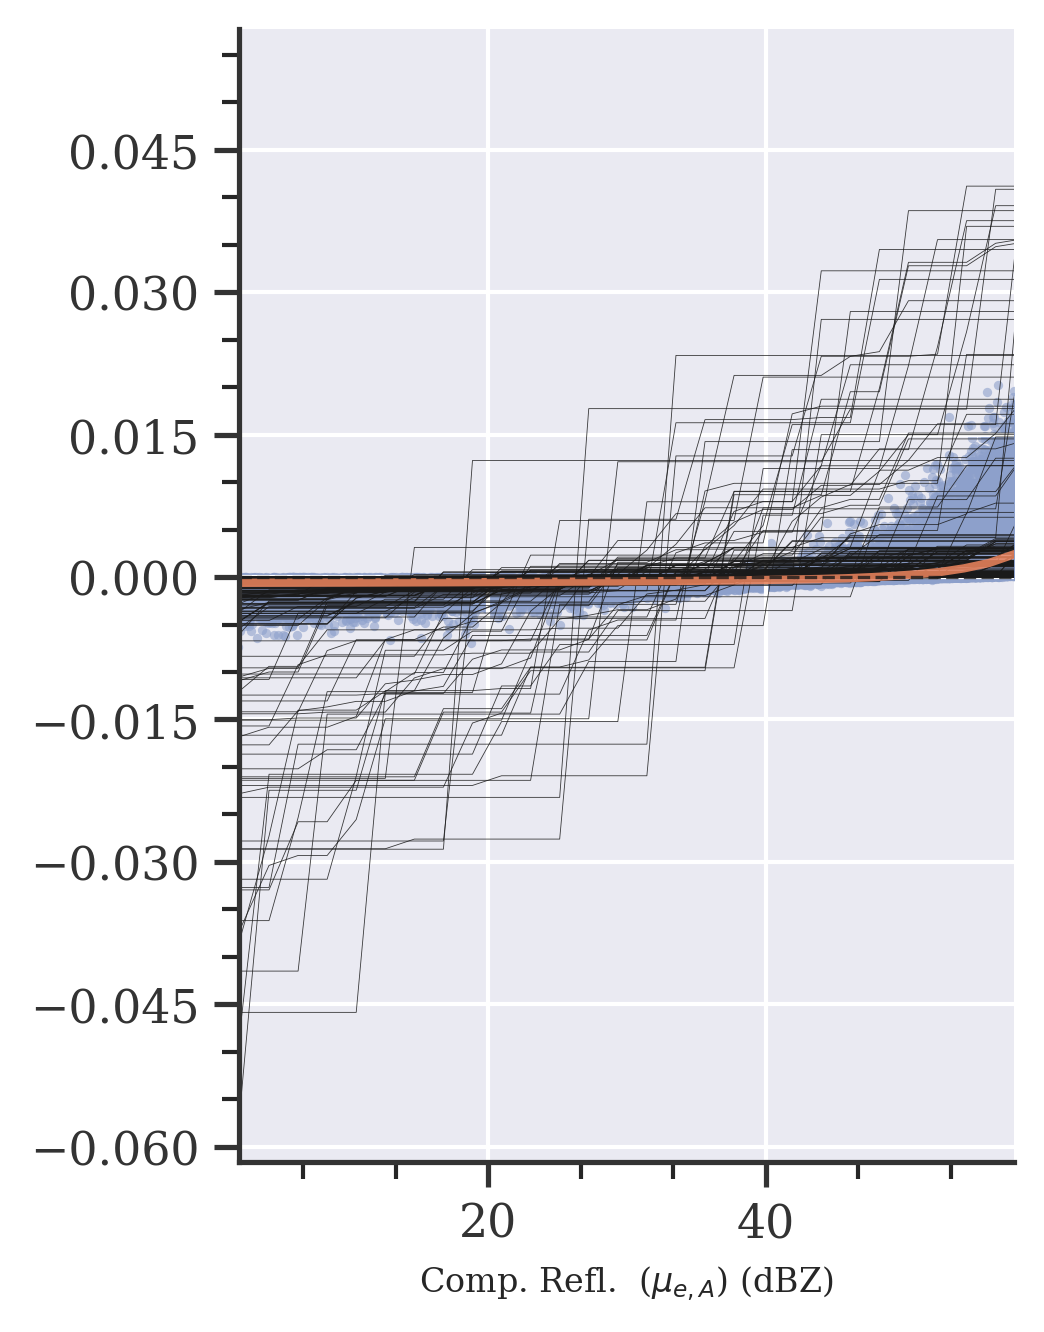

In [8]:
features = ['comp_dz_time_max_ens_mean_of_90th']
feature = features[0]

plotter= PlotStructure(BASE_FONT_SIZE = 16)
fig, ax = plotter.create_subplots(n_panels=len(features), n_columns=2, figsize=(8,5), dpi=300, 
                                      wspace=0.4, hspace=0.35)
# unpack all the axes subplots
ax = ax[0]

colors = list(sns.color_palette("Set2"))

explainer.plot_ale(ale_results, 
                   features = [feature],
                   estimator_names = [estimator_name],
                   add_hist=False, 
                   display_feature_names=display_feature_names,
                   display_units = display_units,
                   ax=ax, line_kws = {'line_colors' : [colors[1]], 'linewidth': 2.0}, 
                   to_probability=False,
                   ice_curves=ice_curves,
                      )


explainer.plot_shap(features=[feature],
                    plot_type = 'dependence',
                    shap_values=shap_ds,
                    estimator_name = estimator_name,
                    display_feature_names=display_feature_names,
                    display_units = display_units,
                    interaction_index=None,
                    color =colors[2],
                    s = 5, 
                    ax=ax,
                    alpha=0.6,
                    to_probability=False,
                    colorbar_pad = 0.25    
    )


    
plotter.set_n_ticks(ax)
plotter.set_minor_ticks(ax)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#plotter.add_alphabet_label(n_panels, axes, pos=(0.9, 0.9))